# Import Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from torchvision import models, transforms, datasets
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from torch.utils.data import SequentialSampler

!pip install torchmetrics
!pip install --upgrade torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 19.8 MB/s eta 0:00:00


In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda') # GPU
else:
  device = torch.device('cpu') # CPU

print(device)
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

cpu
Using 0 GPUs
CUDA is available: False


In [3]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    t_Labels = []
    t_Preds = []

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        t_Labels.extend(labels)
        t_Preds.extend(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time, t_Preds, t_Labels

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    v_Labels = []
    v_Preds = []

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

            v_Labels.extend(labels)
            v_Preds.extend(predicts)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"/content/drive/MyDrive/HW4_dataset/HW4_MobileNetV2_Phase2_model_02.pth")

    return epoch_loss, epoch_acc, total_time, best_acc, v_Preds, v_Labels

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        state_dict = torch.load(model_path, weights_only=True) # Prevent risks with untrusted pickle data.
        model.load_state_dict(state_dict)
        #model.load_state_dict(torch.load(model_path)) # TA's code
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    e_Labels = []
    e_Preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

            e_Labels.extend(labels)
            e_Preds.extend(predicts)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc, e_Preds, e_Labels

# Data Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# define folder path for each set
train_path = '/content/drive/MyDrive/HW4_dataset/train'
test_path = '/content/drive/MyDrive/HW4_dataset/test'
val_path = '/content/drive/MyDrive/HW4_dataset/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)), # Add blur
    transforms.RandomRotation(degrees=10), # Add random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Add color jitter
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=38, shuffle=True) # TA's code shuffle=True
val_loader = DataLoader(val_dataset, batch_size=38, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model

In [6]:
# Load the pre-trained mobilenet_v2 model
model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

# Enable gradient computation only for the classifier
for param in model.classifier.parameters():
  param.requires_grad = True

# Modify the classifier for binary classification
model.classifier[1] = nn.Sequential(
  nn.Linear(1280, 128),
  nn.ReLU(),
  nn.Dropout(0.2),
  nn.Linear(128, 1), # Add addtional fully connection layer
  nn.Sigmoid()  # Add sigmoid activation
  )

model = model.to(device)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 53.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Loop

In [7]:
# hyperparameter
lr = 0.0001 # TA set default lr to 0.001
weight_decay = 0.0001 # TA set default weight_decay to 0.001
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, mode='max') # TA set default patience=5
epochs = 69 # VGG16 train 100sec for a epoch / MobilenetV2 train 14.5sec for a epoch = 6.9 times x 10 epochs
criterion = nn.BCELoss() # TA set default criterion to nn.BCELoss()

# save checkpoint
save = "/content/drive/MyDrive/HW4_dataset/HW4_MobileNetV2_Phase2_model_02.pth"

In [8]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

for epoch in range(epochs):
    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/69 - loss: 0.6889 - train_acc: 51.32% - val_loss: 0.6877 - val_acc: 62.50% - time: 60.68s
Epoch 2/69 - loss: 0.6840 - train_acc: 56.58% - val_loss: 0.6839 - val_acc: 62.50% - time: 15.26s
Epoch 3/69 - loss: 0.6749 - train_acc: 61.84% - val_loss: 0.6774 - val_acc: 68.75% - time: 15.60s
Epoch 4/69 - loss: 0.6694 - train_acc: 63.16% - val_loss: 0.6701 - val_acc: 68.75% - time: 16.07s
Epoch 5/69 - loss: 0.6466 - train_acc: 77.63% - val_loss: 0.6643 - val_acc: 62.50% - time: 16.09s
Epoch 6/69 - loss: 0.6636 - train_acc: 68.42% - val_loss: 0.6602 - val_acc: 50.00% - time: 17.48s
Epoch 7/69 - loss: 0.6414 - train_acc: 75.00% - val_loss: 0.6583 - val_acc: 56.25% - time: 16.23s
Epoch 8/69 - loss: 0.6259 - train_acc: 77.63% - val_loss: 0.6625 - val_acc: 56.25% - time: 15.48s
Epoch 9/69 - loss: 0.6251 - train_acc: 76.32% - val_loss: 0.6651 - val_acc: 56.25% - time: 15.43s
Epoch 10/69 - loss: 0.6191 - train_acc: 81.58% - val_loss: 0.6646 - val_acc: 62.50% - time: 15.34s
Epoch 11/69 - loss:

# Graph

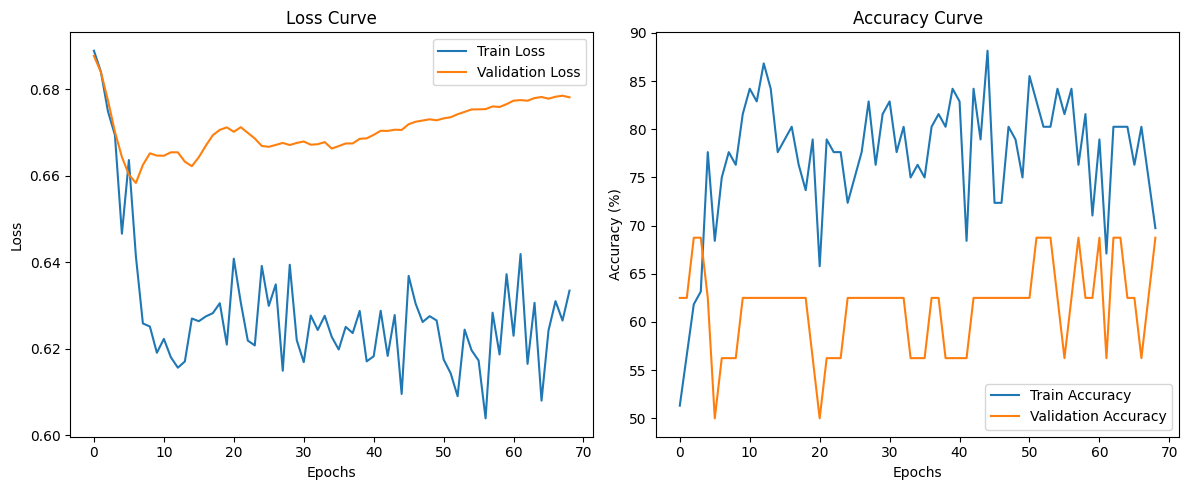

In [9]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [10]:
model_path = "/content/drive/MyDrive/HW4_dataset/HW4_MobileNetV2_Phase2_model_02.pth"
avg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)

Model weights loaded successfully.
Test Accuracy: 62.50%
Test Loss: 0.6773


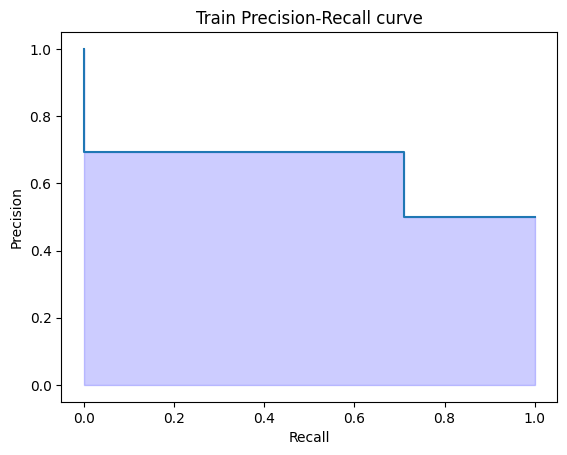

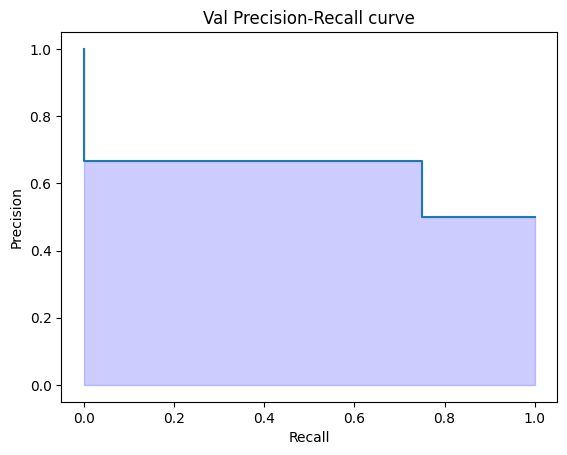

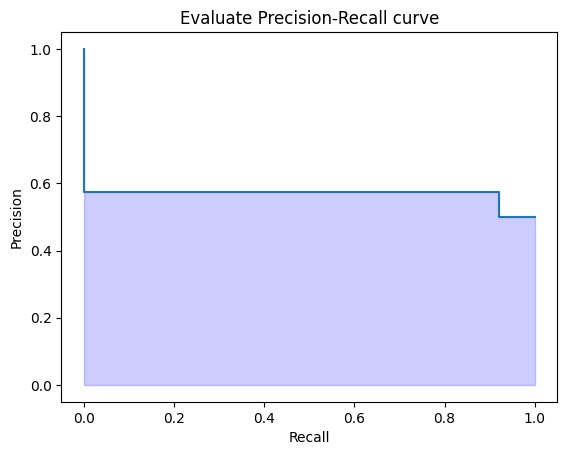

In [11]:
# Plot precision-recall curve
pr_curve = torchmetrics.PrecisionRecallCurve(task='binary')

# Convert to tensors if they are lists
train_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p
train_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l
val_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p
val_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l
eva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p
eva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l

# Convert to float32
train_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor
train_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
val_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
val_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
eva_p = eva_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
eva_l = eva_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long

precision_t, recall_t, thresholds_t = pr_curve(train_p, train_l)
plt.figure()
plt.step(recall_t, precision_t, where='post')
plt.fill_between(recall_t, precision_t, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Train Precision-Recall curve')
plt.show()

precision_v, recall_v, thresholds_v = pr_curve(val_p, val_l)
plt.figure()
plt.step(recall_v, precision_v, where='post')
plt.fill_between(recall_v, precision_v, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Val Precision-Recall curve')
plt.show()

precision_e, recall_e, thresholds_e = pr_curve(eva_p, eva_l)
plt.figure()
plt.step(recall_e, precision_e, where='post')
plt.fill_between(recall_e, precision_e, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Evaluate Precision-Recall curve')
plt.show()